# Background:
In this kaggle competetion, we were given a set of feature describing the effect of various drug on cellular viability and gene expression. Based on these features the task was to predict the mechanism of action of the given drug i.e which protein/pathway the drug inhibits/activates. 

# 1. Data Exploration

In [1]:
# Data reading and visualization
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
sns.set()

# Statistical packages
from scipy.stats import kurtosis, skew

# filter warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# for data preprocessing
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import QuantileTransformer,OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn import metrics

In [3]:
# Package for Multilabel stratification split
! pip install iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
# For modeling
from sklearn.model_selection import train_test_split
import cuml
from cuml.linear_model import LogisticRegression
from xgboost import XGBClassifier

# For hyperparameter tuning

import optuna
from optuna import Trial


In [5]:
import gc # garbage collection

In [6]:
# Loading the data and targets to predict
drug = pd.read_csv('../input/lish-moa/train_features.csv')
targets = pd.read_csv('../input/lish-moa/train_targets_scored.csv')

In [7]:
# Quick check if data is imported properly
drug.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [8]:
print(f"There are total {drug.shape[1]} feature columns and {drug.shape[0]} training examples")

There are total 876 feature columns and 23814 training examples


In [9]:
# Quick info about the data
drug.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23814 entries, 0 to 23813
Columns: 876 entries, sig_id to c-99
dtypes: float64(872), int64(1), object(3)
memory usage: 159.2+ MB


In [10]:
#Quick check if targets are loaded fine
targets.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
print(f"There are total {targets.shape[1]} targets to predict, it is a Multilabel Prediction task")

There are total 207 targets to predict, it is a Multilabel Prediction task


In [12]:
#Quick target info
targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23814 entries, 0 to 23813
Columns: 207 entries, sig_id to wnt_inhibitor
dtypes: int64(206), object(1)
memory usage: 37.6+ MB


In [13]:
print("\"Sig_id\" seems to be a row identifier not a actully a feature")

"Sig_id" seems to be a row identifier not a actully a feature


In [14]:
# This confirm the sig_id is row indentifier
print(f'Is the number of unique values Sig_id column is same as length of data : {drug.sig_id.nunique() == len(drug)}')

Is the number of unique values Sig_id column is same as length of data : True


In [15]:
# Checking if the order of data is same in target and feature sets
if (drug['sig_id'] != targets['sig_id']).sum() == 0:
    print('Training examples in drug and target datasets are same order')
else:
    print('Training examples in drug and target datasets are not in same order')

Training examples in drug and target datasets are same order


In [16]:
# Setting Sig_id as index column
drug.set_index('sig_id', inplace = True)
targets.set_index('sig_id', inplace = True)

In [17]:
## Summary:
print(f"There are {drug.shape[1]} features/independent variable in the dataset.",
     f"There are {drug.shape[0]} training examples in the dataset.",
     f"There are {targets.shape[1]} targets to predict.", sep = '\n')

There are 875 features/independent variable in the dataset.
There are 23814 training examples in the dataset.
There are 206 targets to predict.


**Spliting data into training and test datasets to avoid data leakage**

In [18]:
trainx, testx, trainy, testy = train_test_split(drug, targets, test_size = 0.15, shuffle = True, random_state = 42)

In [19]:
print(f"Dimensions of the training set data : {(trainx.shape, trainy.shape)}",
    f"Dimensions of the test set data : {(testx.shape, testy.shape)}", sep= '\n')

Dimensions of the training set data : ((20241, 875), (20241, 206))
Dimensions of the test set data : ((3573, 875), (3573, 206))


In [20]:
print("Data types of features :", trainx.dtypes.value_counts(), sep = '\n')

Data types of features :
float64    872
object       2
int64        1
dtype: int64


# 2. Feature Information:
1) cp_type (type- category): 
Type of treatment given to the cells. Cells were  either given a placebo/vehicle(control) or drug (treatment) and various responses were analysed.

2) cp_time (type- Integer): 
Time periods after which the response was recorded, it is either 24hr, 48 hr or 72 hrs

3) cp_dose (type- category):
Doses of drug/vehicle used

4) Cell Viability features (type- float): 
There are anonymized features based on cell viability defects upon drug/vehicle treatment

5) Gene expression based feature (type- float): 
These are the quantified gene expression changes upon drug/vehicle treatment. There features are anonymized as well

In [21]:
print(f'Total cell viability features is {len([i for i in trainx.columns if i.startswith("c-")])}', 
      f'Total gene expression based features are {len([i for i in trainx.columns if i.startswith("g-")])}', sep ='\n')

Total cell viability features is 100
Total gene expression based features are 772


In [22]:
# getting names of feature columns based on the their data types
cat_cols = trainx.select_dtypes(include = 'O').columns.tolist()
num_cols = trainx.select_dtypes(exclude = 'O').columns.tolist()
gene_expression_features = [i for i in trainx.columns if i.startswith('g-')]
cell_vibility_features = [i for i in trainx.columns if i.startswith('c-')]

In [23]:
cat_cols

['cp_type', 'cp_dose']

In [24]:
# Analysing different categories in catergorical columns
for col in cat_cols:
    print(trainx[col].value_counts(), '\n')
    print(trainx[col].value_counts('normalized'), end = '\n\n')

trt_cp         18650
ctl_vehicle     1591
Name: cp_type, dtype: int64 

trt_cp         0.921397
ctl_vehicle    0.078603
Name: cp_type, dtype: float64

D1    10316
D2     9925
Name: cp_dose, dtype: int64 

D1    0.509659
D2    0.490341
Name: cp_dose, dtype: float64



In [25]:
trainx.describe()

,cp_time,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
count,20241.000000,20241.000000,20241.000000,20241.000000,20241.000000,20241.000000,20241.000000,20241.000000,20241.000000,20241.000000,...,20241.000000,20241.000000,20241.000000,20241.000000,20241.000000,20241.000000,20241.000000,20241.000000,20241.000000,20241.000000
mean,47.985771,0.251572,-0.093551,0.152177,0.083230,0.057521,-0.137225,0.035958,-0.200897,-0.187524,...,-0.472865,-0.468074,-0.518436,-0.501028,-0.510924,-0.354226,-0.468644,-0.382245,-0.473039,-0.301056
std,19.414019,1.391394,0.812251,1.036033,0.950318,1.038877,1.182830,0.885881,1.127082,1.750626,...,2.009747,2.051290,2.009206,2.108718,2.164027,1.634598,2.063733,1.711336,1.838975,1.409361
min,24.000000,-5.513000,-5.737000,-9.104000,-5.998000,-6.369000,-10.000000,-10.000000,-10.000000,-10.000000,...,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000
25%,24.000000,-0.469900,-0.559000,-0.440200,-0.427600,-0.472900,-0.601100,-0.498700,-0.521700,-0.512000,...,-0.568600,-0.566000,-0.592100,-0.567700,-0.568300,-0.568700,-0.550700,-0.562000,-0.593000,-0.563700
50%,48.000000,-0.005600,-0.045900,0.075000,0.006700,-0.026300,-0.013400,-0.000400,-0.015300,0.012800,...,-0.008600,0.000400,-0.008800,-0.013700,-0.002100,-0.008600,-0.003300,-0.008300,0.014000,-0.018300
75%,72.000000,0.528300,0.401700,0.667100,0.467400,0.465700,0.515200,0.532800,0.413900,0.556200,...,0.458100,0.455400,0.447300,0.453200,0.468500,0.448600,0.461500,0.443400,0.460800,0.440000
max,72.000000,10.000000,5.039000,8.257000,10.000000,10.000000,7.282000,7.333000,5.473000,8.887000,...,4.069000,3.960000,3.841000,3.288000,3.747000,2.814000,3.505000,2.799000,3.111000,3.805000


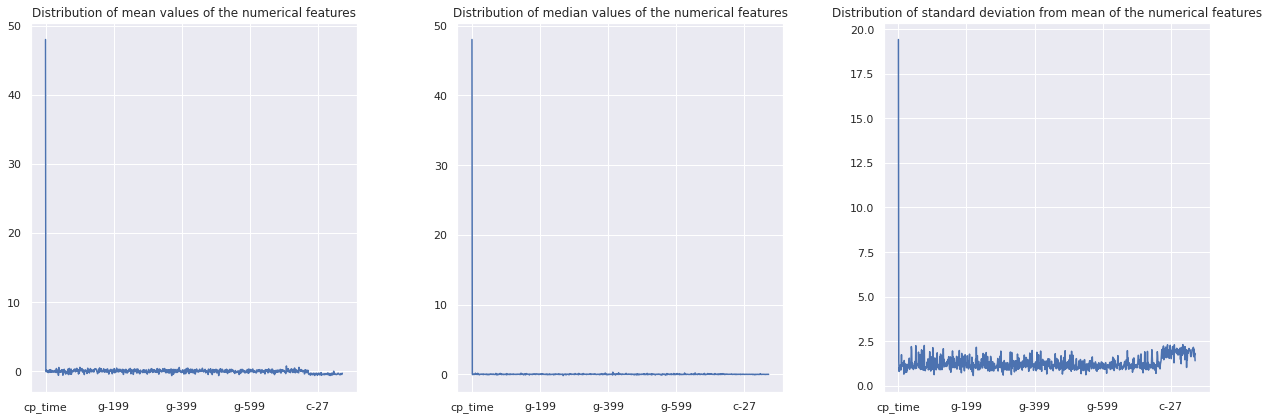

In [26]:
# Preliminary analysis based of above results
plt.figure(figsize = (18,6))
plt.subplot(1, 3, 1)
trainx.describe().loc['mean', :].plot()
plt.title('Distribution of mean values of the numerical features')

plt.subplot(1, 3, 2)
trainx.describe().loc['50%', :].plot()
plt.title('Distribution of median values of the numerical features')

plt.subplot(1, 3, 3)
trainx.describe().loc['std', :].plot()
plt.title('Distribution of standard deviation from mean of the numerical features')
plt.tight_layout()

### (A) Running Summaries:
* Most numerical features are in zero centered, except for cp_time



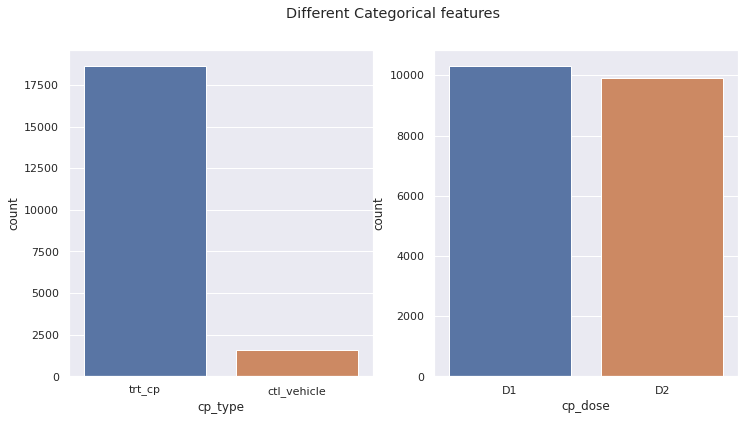

In [27]:
plt.figure(figsize = (12, 6))
plt.suptitle('Different Categorical features')
for e, col in enumerate(cat_cols):
    plt.subplot(1,2, e+1)
    sns.countplot(trainx[col])

### (A) Running Summaries:
* Most numerical features are in zero centered, except for cp_time
* Most training examples are of sample treated with the drug

# 3. Analysis of Gene Expression features

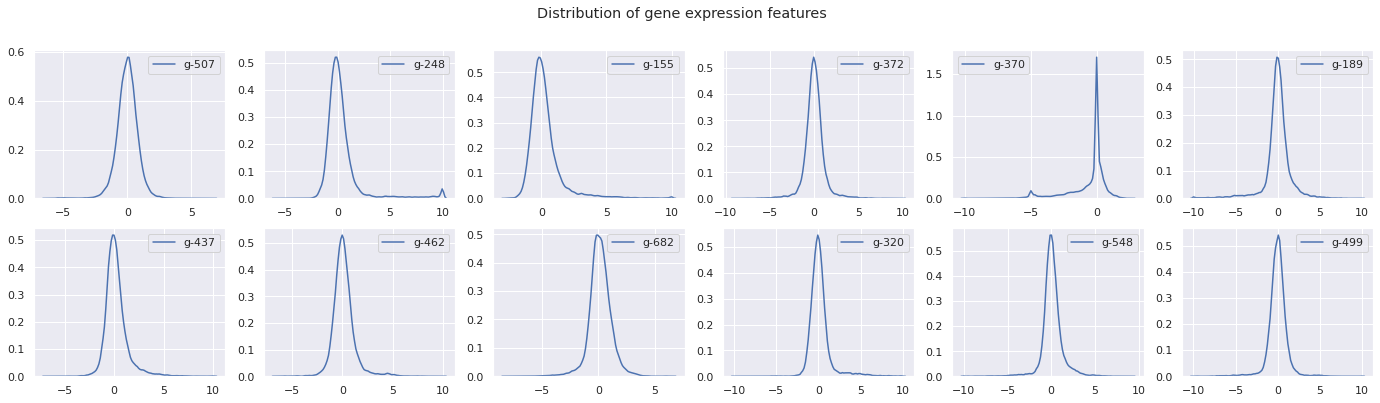

In [28]:
plt.figure(figsize = (24, 6))
plt.suptitle('Distribution of gene expression features')
for e, col in enumerate(np.random.choice(gene_expression_features, size = 12)):
    plt.subplot(2,6, e+1)
    sns.kdeplot(trainx[col])

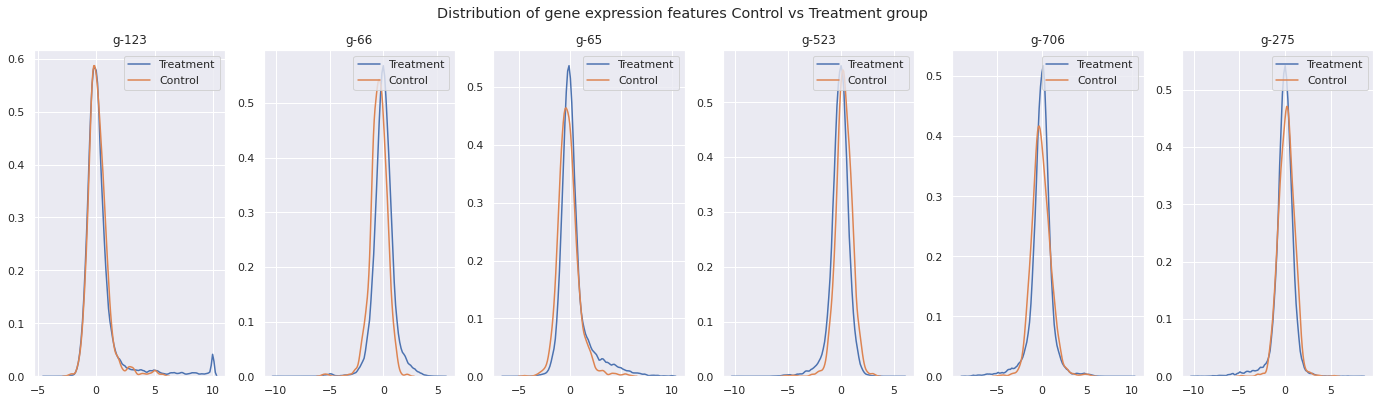

In [29]:
plt.figure(figsize = (24, 6))
plt.suptitle('Distribution of gene expression features Control vs Treatment group')
for e, col in enumerate(np.random.choice(gene_expression_features, size = 6)):
    plt.subplot(1,6, e+1)
    sns.kdeplot(trainx.query('cp_type == "trt_cp"')[col], label = 'Treatment')
    sns.kdeplot(trainx.query('cp_type != "trt_cp"')[col], label = 'Control')
    plt.legend(loc = 'upper right')
    plt.title(col)

* Gene expression distribution very similar for treatment and control group

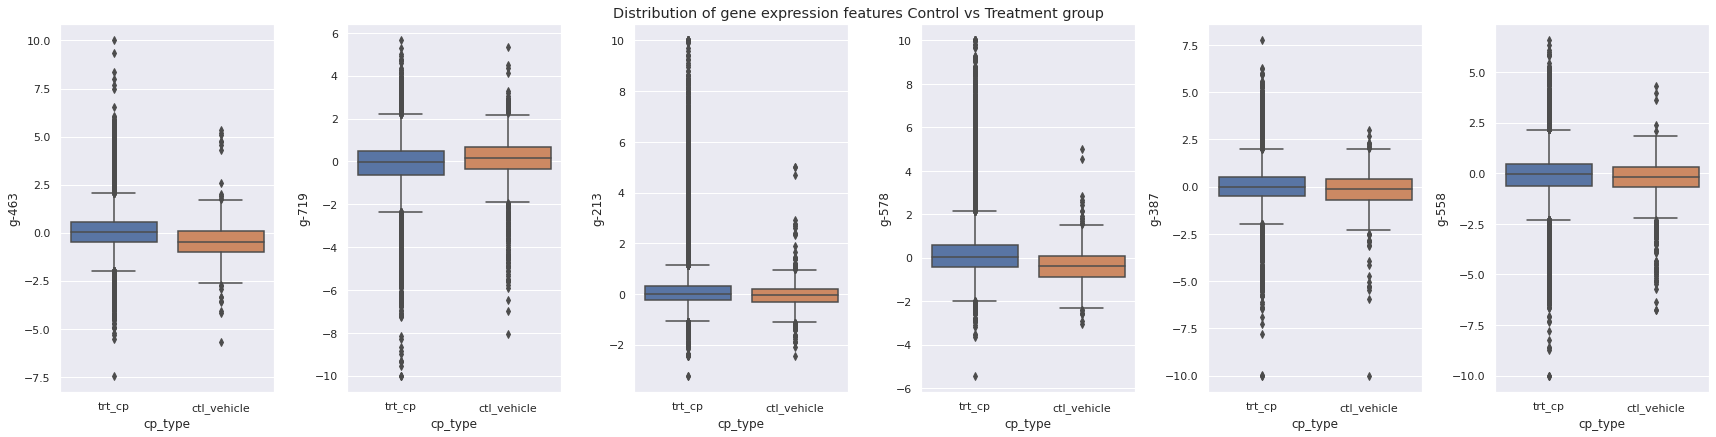

In [30]:
# Analysis of gene expression levels of control and treatment group
plt.figure(figsize = (24, 6))
plt.suptitle('Distribution of gene expression features Control vs Treatment group', y = 1.01)
for e, col in enumerate(np.random.choice(gene_expression_features, size = 6, )):
    plt.subplot(1,6, e+1)
    sns.boxplot(data= trainx, x = 'cp_type', y = col)
plt.tight_layout()

* Gene expression distribution very similar for treatment and control group

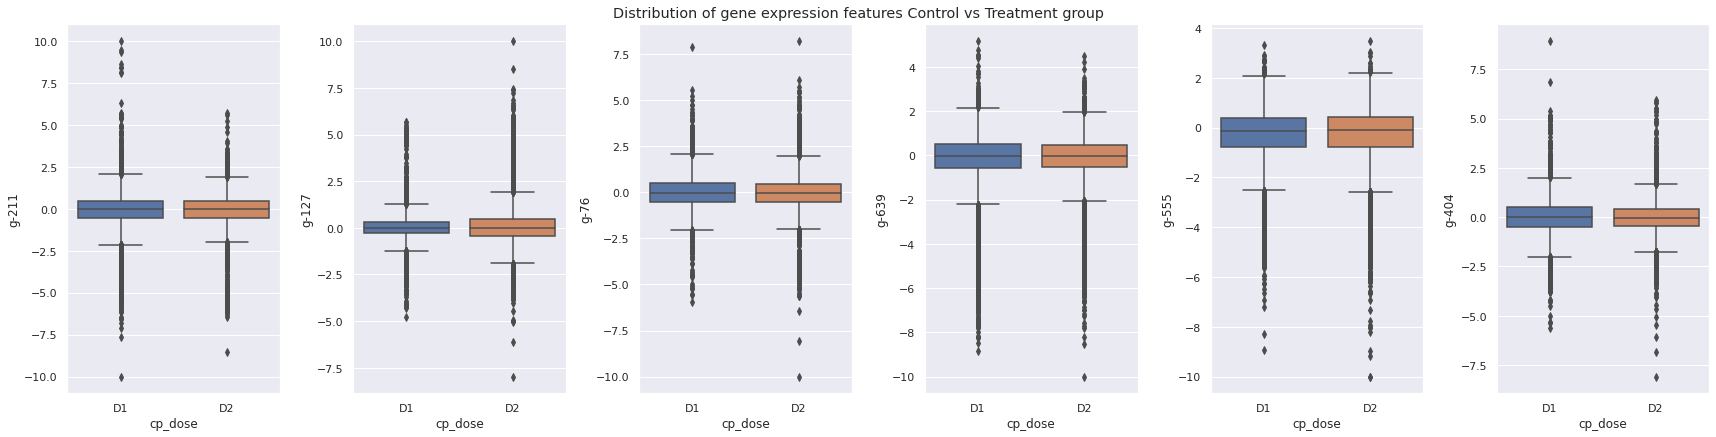

In [31]:
# Analysis of gene expression levels of control and treatment group at different doses
plt.figure(figsize = (24, 6))
plt.suptitle('Distribution of gene expression features Control vs Treatment group', y = 1.01)
for e, col in enumerate(np.random.choice(gene_expression_features, size = 6)):
    plt.subplot(1,6, e+1)
    sns.boxplot(data= trainx, x = 'cp_dose', y = col)
    #plt.title(col)
plt.tight_layout()

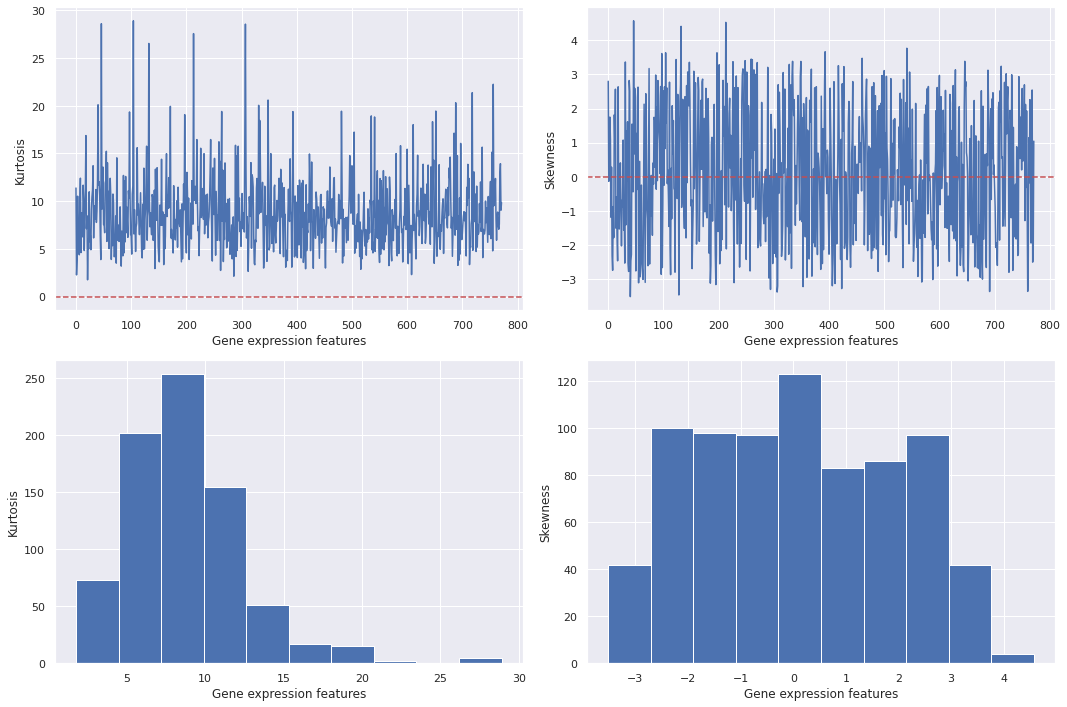

In [32]:
# Analysis of Kurtosis and skewness of the gene expression features
plt.figure(figsize = (15,10))
plt.subplot(2,2,1)
plt.plot(kurtosis(trainx[gene_expression_features]))
plt.axhline(y = 0, color = 'r', ls = '--')
plt.xlabel('Gene expression features')
plt.ylabel('Kurtosis')


plt.subplot(2,2,2)
plt.plot(skew(trainx[gene_expression_features]))
plt.axhline(y = 0, color = 'r', ls = '--')
plt.xlabel('Gene expression features')
plt.ylabel('Skewness')

plt.subplot(2,2,3)
plt.hist(kurtosis(trainx[gene_expression_features]))
plt.xlabel('Gene expression features')
plt.ylabel('Kurtosis')


plt.subplot(2,2,4)
plt.hist(skew(trainx[gene_expression_features]))
plt.xlabel('Gene expression features')
plt.ylabel('Skewness')

plt.tight_layout()

### to do: Transformation of gene expression features are needed as kurtosis and skewness are above zero

In [33]:
qt = QuantileTransformer(output_distribution= 'normal')

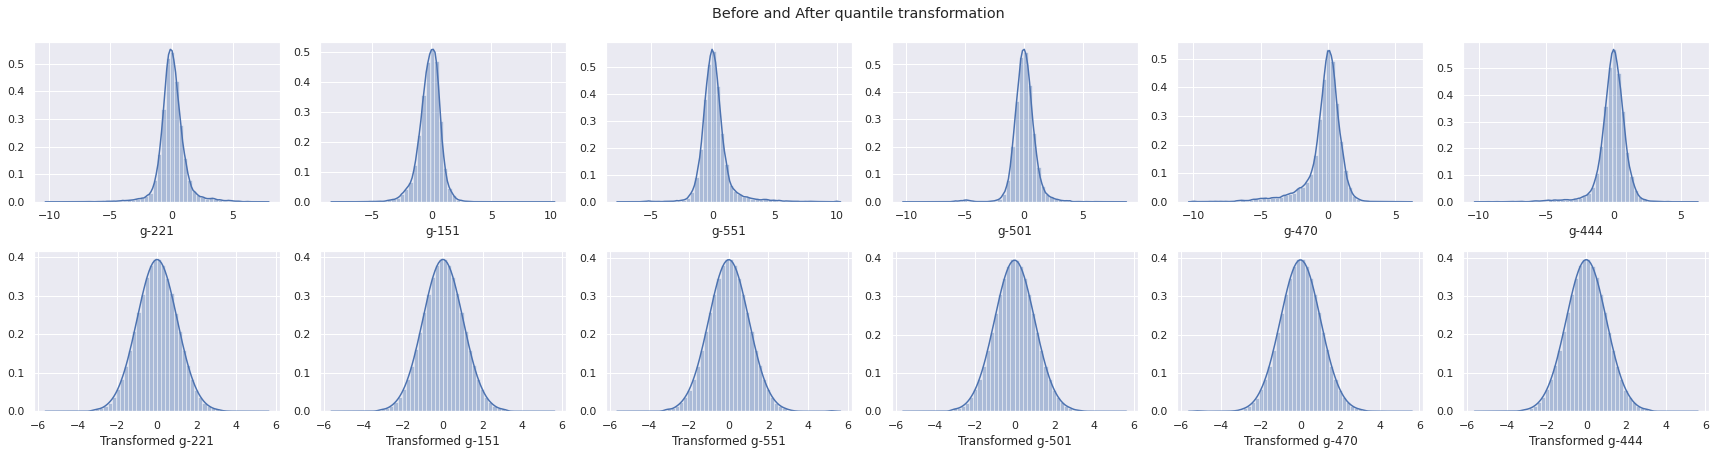

In [34]:
plt.figure(figsize = (24, 6))
plt.suptitle('Before and After quantile transformation',y = 1.05 )
for e, col in enumerate(np.random.choice(gene_expression_features, size = 6)):
    plt.subplot(2,6, e+1)
    sns.distplot(trainx[[col]])
    plt.xlabel(col)
    plt.subplot(2,6, e+1+6)
    sns.distplot(qt.fit_transform(trainx[[col]]))
    plt.xlabel(f'Transformed {col}')
plt.tight_layout()

Text(0.5, 1.0, 'Sperman correlation higher than 0.8')

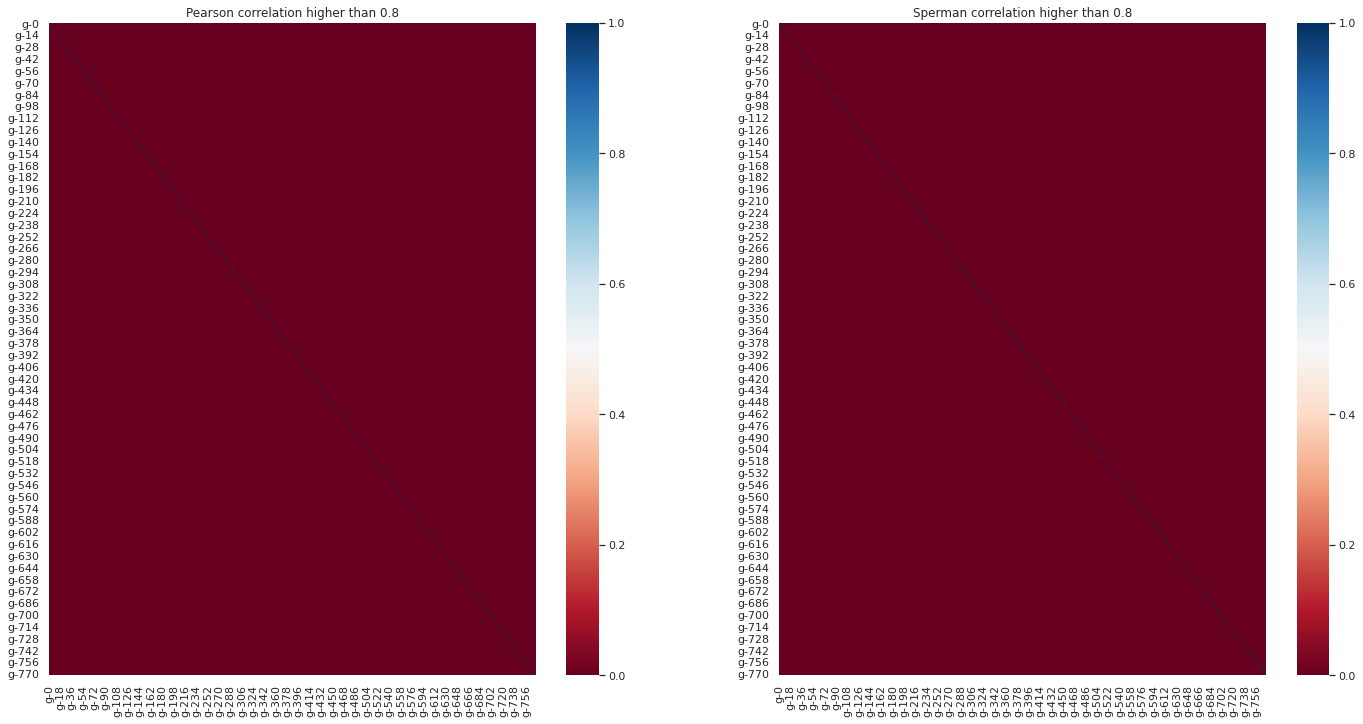

In [35]:
# analysing corelation between the gene expression features
pearson_corr = trainx[gene_expression_features].corr('pearson')
spearman_corr = trainx[gene_expression_features].corr('spearman')
plt.figure(figsize = (24,12))
plt.subplot(1,2,1)
sns.heatmap(pearson_corr>0.8, cmap = 'RdBu')
plt.title('Pearson correlation higher than 0.8')
plt.subplot(1,2,2)
sns.heatmap(pearson_corr>0.8, cmap = 'RdBu')
plt.title('Sperman correlation higher than 0.8')

## (A) Running Summaries:
* Guassian transformation are need for the gene expression datasets
* Very few highly co-related features in gene expression featuresets

# 4. Cell Viability Features analysis

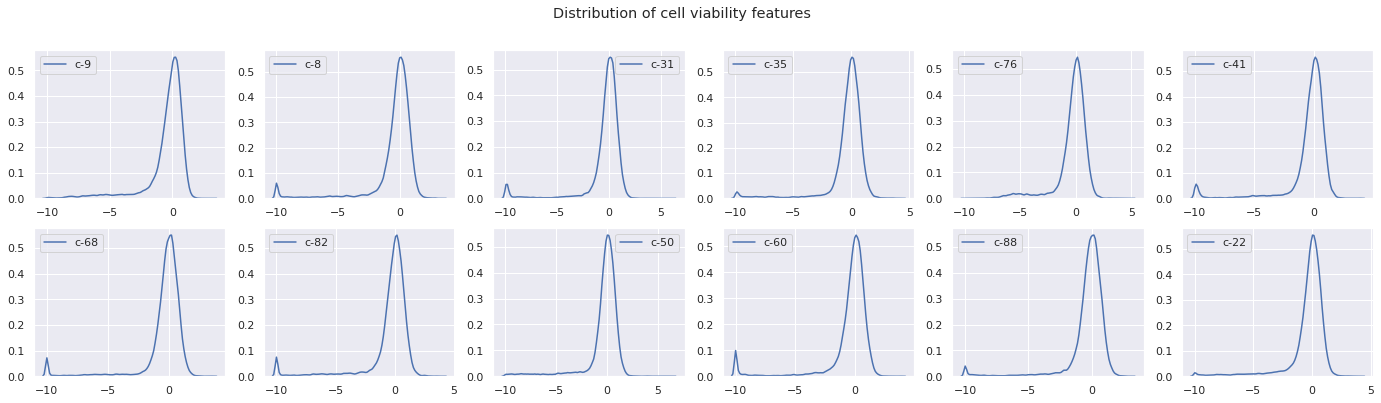

In [36]:
plt.figure(figsize = (24, 6))
plt.suptitle('Distribution of cell viability features')
for e, col in enumerate(np.random.choice(cell_vibility_features, size = 12)):
    plt.subplot(2,6, e+1)
    sns.kdeplot(trainx[col])

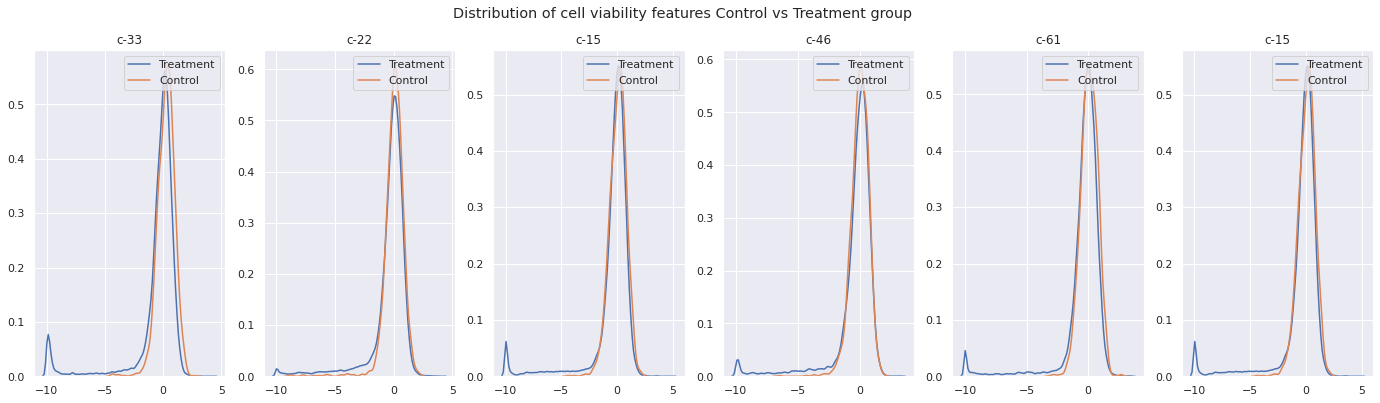

In [37]:
plt.figure(figsize = (24, 6))
plt.suptitle('Distribution of cell viability features Control vs Treatment group')
for e, col in enumerate(np.random.choice(cell_vibility_features, size = 6)):
    plt.subplot(1,6, e+1)
    sns.kdeplot(trainx.query('cp_type == "trt_cp"')[col], label = 'Treatment')
    sns.kdeplot(trainx.query('cp_type != "trt_cp"')[col], label = 'Control')
    plt.legend(loc = 'upper right')
    plt.title(col)

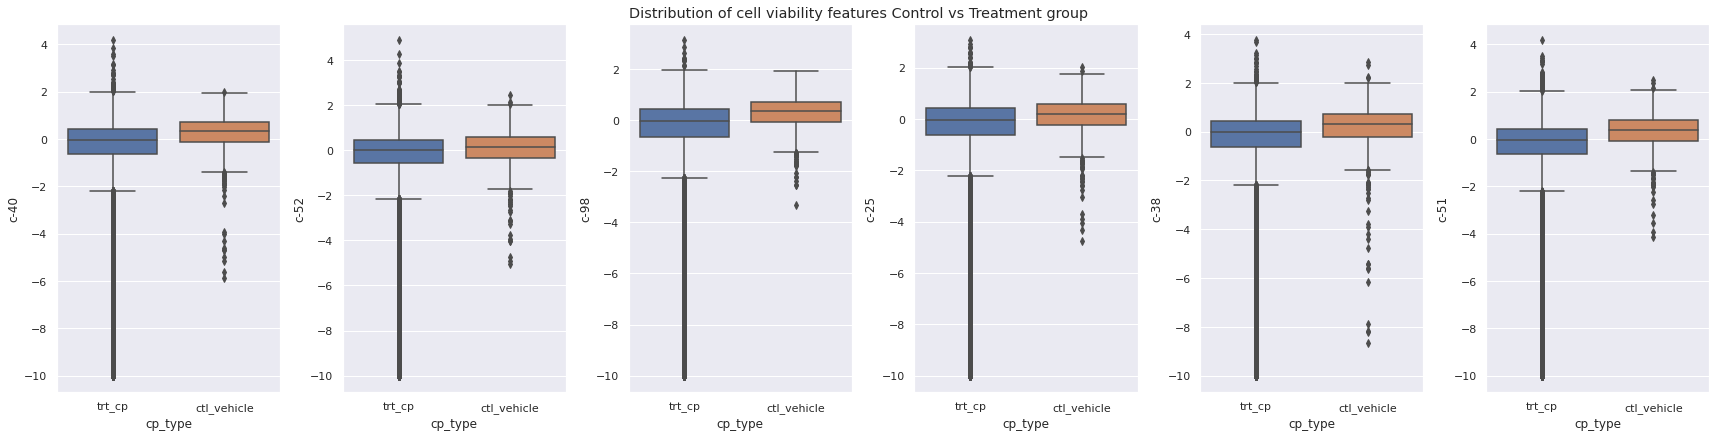

In [38]:
plt.figure(figsize = (24, 6))
plt.suptitle('Distribution of cell viability features Control vs Treatment group', y = 1.01)
for e, col in enumerate(np.random.choice(cell_vibility_features, size = 6, )):
    plt.subplot(1,6, e+1)
    sns.boxplot(data= trainx, x = 'cp_type', y = col)
plt.tight_layout()

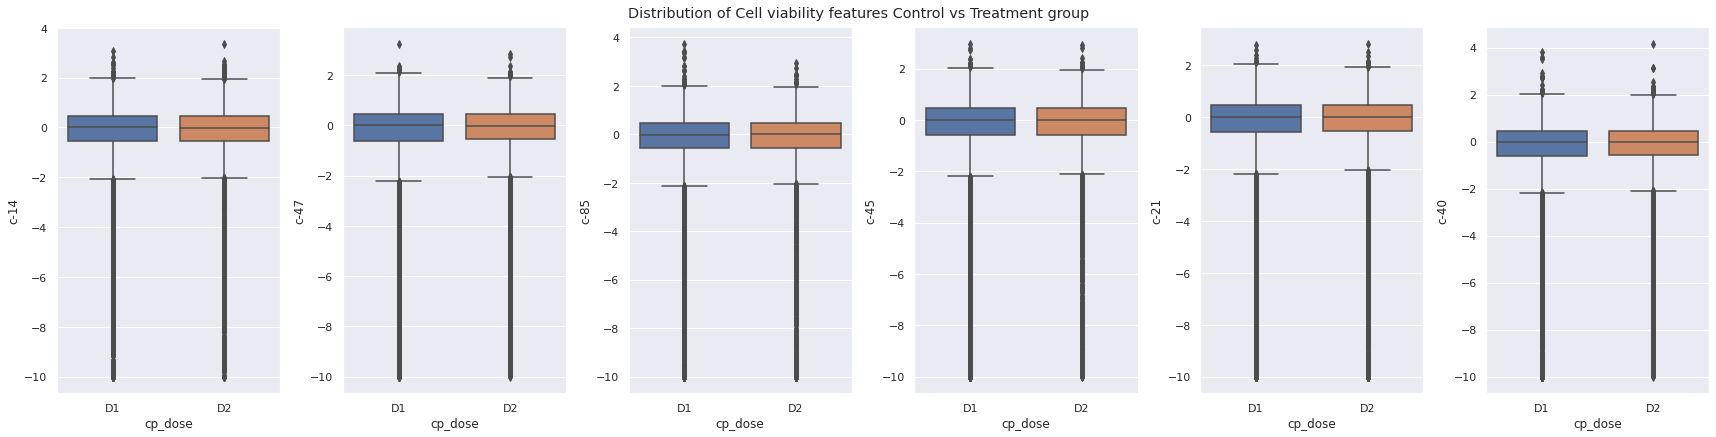

In [39]:
plt.figure(figsize = (24, 6))
plt.suptitle('Distribution of Cell viability features Control vs Treatment group', y = 1.01)
for e, col in enumerate(np.random.choice(cell_vibility_features, size = 6)):
    plt.subplot(1,6, e+1)
    sns.boxplot(data= trainx, x = 'cp_dose', y = col)
    #plt.title(col)
plt.tight_layout()

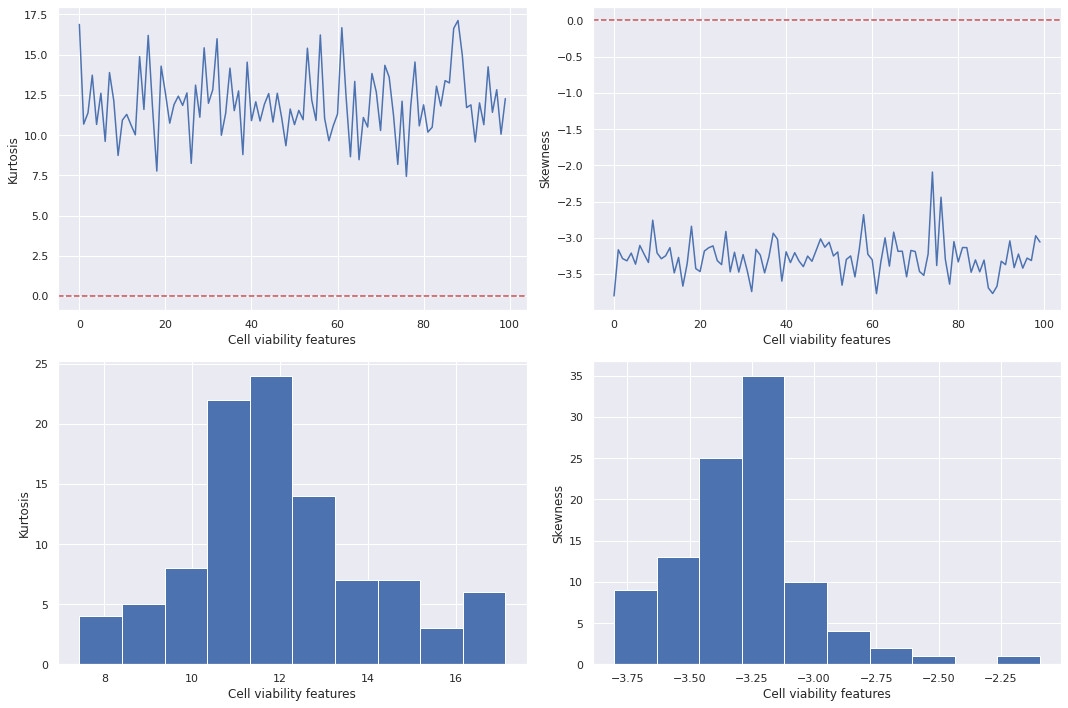

In [40]:
plt.figure(figsize = (15,10))
plt.subplot(2,2,1)
plt.plot(kurtosis(trainx[cell_vibility_features]))
plt.axhline(y = 0, color = 'r', ls = '--')
plt.xlabel('Cell viability features')
plt.ylabel('Kurtosis')


plt.subplot(2,2,2)
plt.plot(skew(trainx[cell_vibility_features]))
plt.axhline(y = 0, color = 'r', ls = '--')
plt.xlabel('Cell viability features')
plt.ylabel('Skewness')

plt.subplot(2,2,3)
plt.hist(kurtosis(trainx[cell_vibility_features]))
plt.xlabel('Cell viability features')
plt.ylabel('Kurtosis')


plt.subplot(2,2,4)
plt.hist(skew(trainx[cell_vibility_features]))
plt.xlabel('Cell viability features')
plt.ylabel('Skewness')

plt.tight_layout()

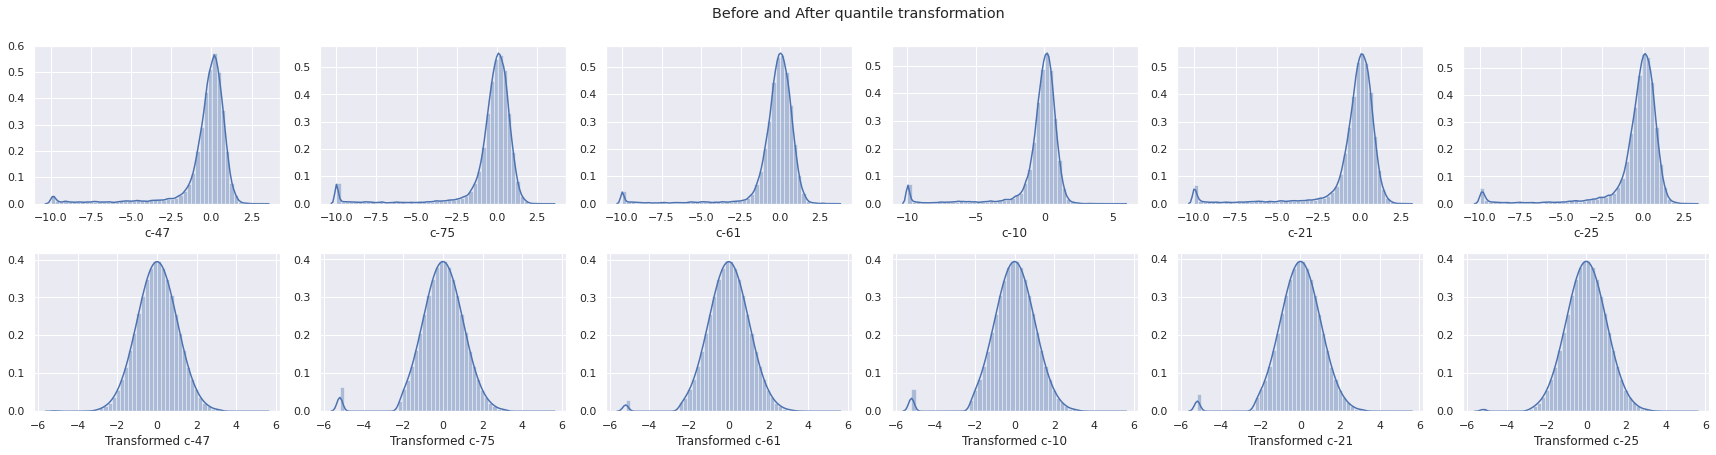

In [41]:
plt.figure(figsize = (24, 6))
plt.suptitle('Before and After quantile transformation',y = 1.05 )
for e, col in enumerate(np.random.choice(cell_vibility_features, size = 6)):
    plt.subplot(2,6, e+1)
    sns.distplot(trainx[[col]])
    plt.xlabel(col)
    plt.subplot(2,6, e+1+6)
    sns.distplot(qt.fit_transform(trainx[[col]]))
    plt.xlabel(f'Transformed {col}')
plt.tight_layout()

### to do: Transformation of gene expression features are needed as kurtosis and skewness are above zero

Text(0.5, 1.0, 'Sperman correlation higher than 0.8')

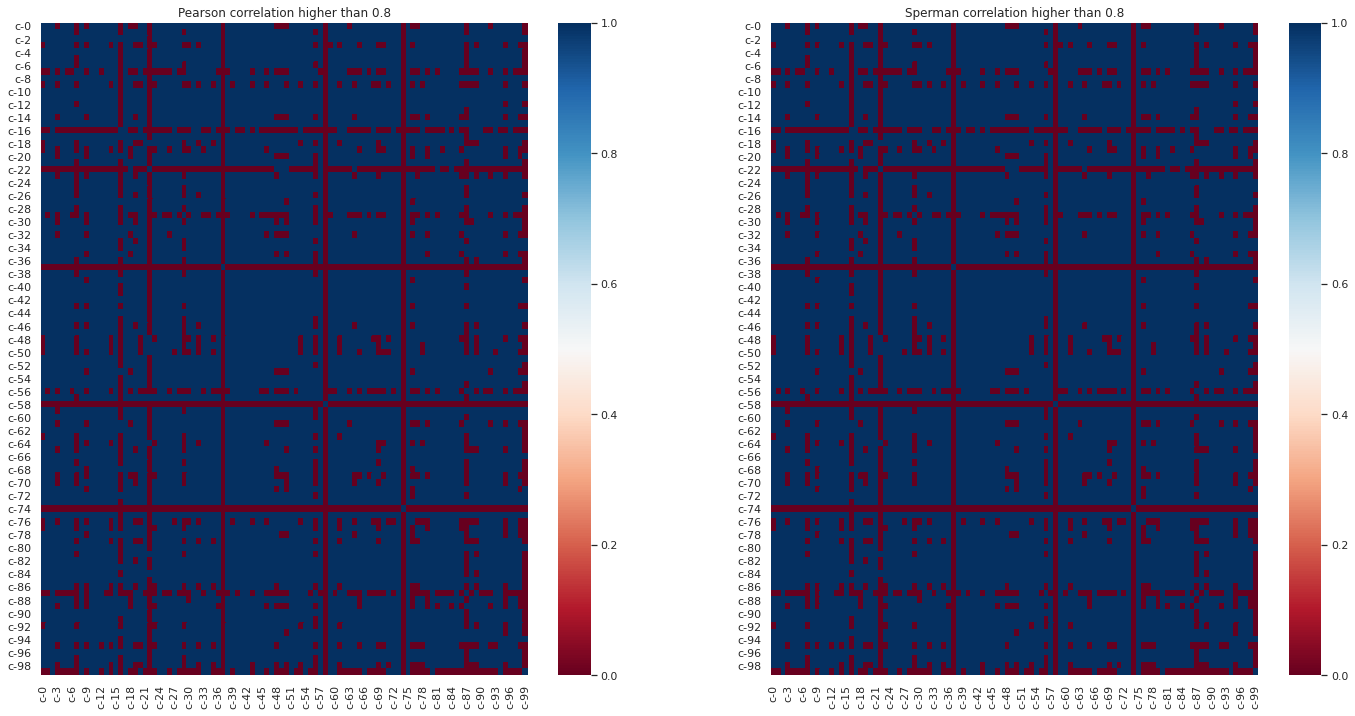

In [42]:
# analysing corelation between the Cell viability features
pearson_corr = trainx[cell_vibility_features].corr('pearson')
spearman_corr = trainx[cell_vibility_features].corr('spearman')
plt.figure(figsize = (24,12))
plt.subplot(1,2,1)
sns.heatmap(pearson_corr>0.8, cmap = 'RdBu')
plt.title('Pearson correlation higher than 0.8')
plt.subplot(1,2,2)
sns.heatmap(pearson_corr>0.8, cmap = 'RdBu')
plt.title('Sperman correlation higher than 0.8')

* Many highly corelated features amongs cell viability columns
* Potential to remove highly correlated featuers using PCA or other dimensionaly reduction/feature selection techniques

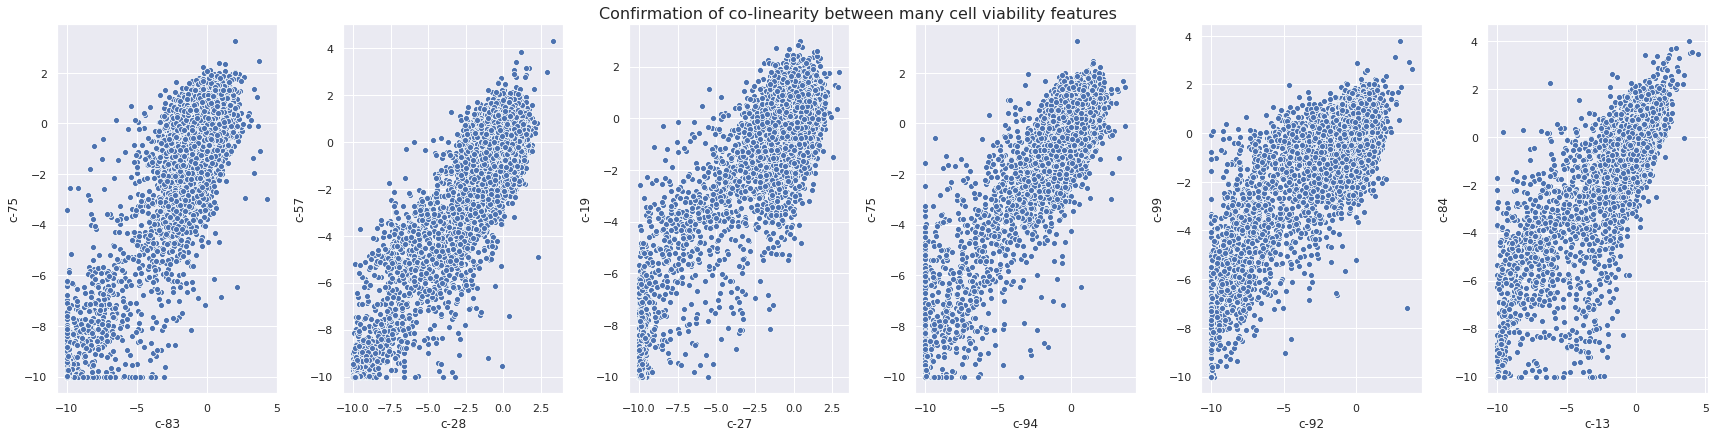

In [43]:
plt.figure(figsize = (24, 6))
plt.suptitle('Confirmation of co-linearity between many cell viability features', y = 1.01, fontsize = 16)
for e, col in enumerate(np.random.choice(cell_vibility_features, size = (6,2))):
    plt.subplot(1,6, e+1)
    sns.scatterplot(data= trainx, x = col[0], y = col[1])
plt.tight_layout()

# 5. Analysis of target

In [44]:
print(f"Number of targets to predict = {targets.shape[1]}")

Number of targets to predict = 206


In [45]:
targets.sum().index

Index(['5-alpha_reductase_inhibitor', '11-beta-hsd1_inhibitor',
       'acat_inhibitor', 'acetylcholine_receptor_agonist',
       'acetylcholine_receptor_antagonist', 'acetylcholinesterase_inhibitor',
       'adenosine_receptor_agonist', 'adenosine_receptor_antagonist',
       'adenylyl_cyclase_activator', 'adrenergic_receptor_agonist',
       ...
       'tropomyosin_receptor_kinase_inhibitor', 'trpv_agonist',
       'trpv_antagonist', 'tubulin_inhibitor', 'tyrosine_kinase_inhibitor',
       'ubiquitin_specific_protease_inhibitor', 'vegfr_inhibitor', 'vitamin_b',
       'vitamin_d_receptor_agonist', 'wnt_inhibitor'],
      dtype='object', length=206)

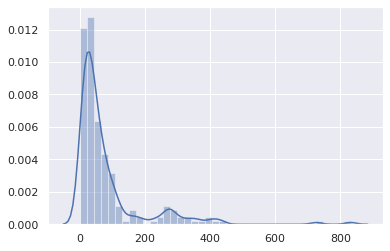

In [46]:
sns.distplot(targets.sum().values)

In [47]:
print(f"Label with least positive example \n{targets.sum().sort_values().head(1)}, \n\nAnd Label with most positive example \n{targets.sum().sort_values().tail(1)}")

Label with least positive example 
atp-sensitive_potassium_channel_antagonist    1
dtype: int64, 

And Label with most positive example 
nfkb_inhibitor    832
dtype: int64


## (A) Running Summaries:
* Guassian transformation are need for the gene expression datasets
* Very few highly co-related features in gene expression featuresets
* Cell viability features have a lot of highly co-related features and also needs Gaussian transformation
* Hug class imbalance in the datasets 

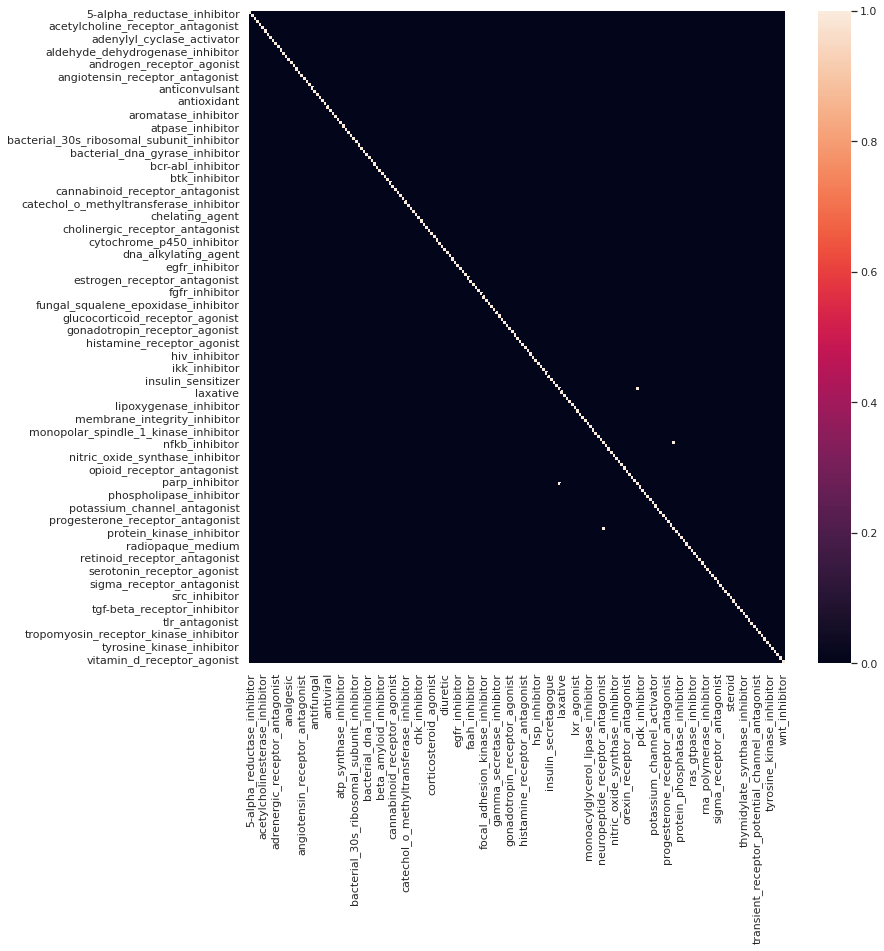

In [48]:
plt.figure(figsize = (12,12))
sns.heatmap(targets.corr('pearson') >0.8)

# 6. Modeling

## So far we know:
1) Gaussian Transformations are required for the Gene expression and Cell vaibility features

2) Feature selection, dimensionality reduction could help as there are co-linear features in the datasets

3) Target class is highly imbalanced Iterative stratification techniques would be needed

4) This Multi-label classification problem and as per the requirement of the competetion, the goal is to have a model with the least log loss values


In [49]:
# label encoding of datasets
categories = cat_cols + ['cp_time'] # for encoding
conti_features = gene_expression_features + cell_vibility_features # for gaussian transformation

ct = ColumnTransformer(
    [('oe', OrdinalEncoder(), categories),
     ('qt', QuantileTransformer(output_distribution = 'uniform'), conti_features)]
)

## 6.1 Logistic Regression with Multioutput

### Hyperparameter tuning with Optuna

In [50]:

# def log_reg(trial,train_set, eval_set): # creating a objective function for optuna hyperparameter tuning
    
#     trainx, trainy = train_set
#     valx, valy = eval_set
#     penalty = trial.suggest_categorical(name = 'penalty', choices = ['l1', 'l2']) # search space of penalty type for logistic regression
    
#     C = trial.suggest_float('C', low= 0.001, high = 0.2) # search space for inverse regularization term 
    
    
#     n_components = trial.suggest_int('n_components', 
#                                     low = 50 ,high = 800)  
    
#     svd = cuml.TruncatedSVD(n_components= n_components)
#     lr = cuml.LogisticRegression(penalty = penalty, C = C, max_iter = 2000)
#     pipe = make_pipeline(svd, MultiOutputClassifier(lr))
#     pipe.fit(trainx, trainy)
#     prob = np.array(pipe.predict_proba(valx))[:,:,1].T
#     logloss = metrics.log_loss(np.ravel(valy), np.ravel(prob), eps = 1e-7)
    
#     return logloss


In [51]:
# lr_study1= optuna.create_study(direction = 'minimize', sampler = optuna.samplers.TPESampler(), study_name = 'Log_svd optimiziation2')
# lr_study1.optimize(lambda trial: log_reg(trial, (train_x, train_y), (val_x, valy)), n_trials = 40, show_progress_bar = True)
# gc.collect()

In [52]:
# # Optimization history
# optuna.visualization.plot_optimization_history(lr_study2)

In [53]:
# lr_study.best_params

In [54]:
# Parameters obtained after the hyperparameter tuning

params = {'penalty': 'l2', 'C': 0.06538522035505716, 'n_components': 716}


In [55]:
# Final Training
svd = cuml.TruncatedSVD(n_components= 716)
lr = cuml.LogisticRegression(penalty = 'l2', C = 0.0654, max_iter = 2500)
lr_pipe = make_pipeline(ct, svd, MultiOutputClassifier(lr))

In [56]:
# Cross Validation across all the folds

def multilabelstratified_cv(model, test_set, n_split = 5, return_oof= True):
    (trainx, trainy) = test_set
    
    oof_pred = np.zeros(trainy.shape)
    cv_auc = []
    cv_logloss = [] 
    cv_auc_train = []
    cv_logloss_train = [] 
    # Multilabel Stratification of the data for CV
    
    for e, (train_id, test_id) in enumerate(MultilabelStratifiedShuffleSplit(n_splits = n_split, test_size = 0.2).split(trainx, trainy)):
        train_x, train_y = trainx.iloc[train_id], trainy.iloc[train_id]
        valx, valy = trainx.iloc[test_id], trainy.iloc[test_id]
        
        # Fitting the model
        model.fit(train_x, train_y)
        # Calculating Train and validation probabilities
        
        temp_train_prob = np.array(model.predict_proba(train_x))[:,:,1].T
        temp_val_prob = np.array(model.predict_proba(valx))[:,:,1].T
        
        # Append to OOF set
        oof_pred[test_id] = temp_val_prob[:]
        
        # Calculating Log loss and ROC AUC scores of the training and validation fold
        
        
        temp_train_auc = metrics.roc_auc_score(np.ravel(train_y), np.ravel(temp_train_prob))
        temp_train_loss = metrics.log_loss(np.ravel(train_y), np.ravel(temp_train_prob), eps = 1e-7)
        
        temp_val_auc = metrics.roc_auc_score(np.ravel(valy), np.ravel(temp_val_prob))
        temp_val_loss = metrics.log_loss(np.ravel(valy), np.ravel(temp_val_prob), eps = 1e-7)
        
        print(f"Training log loss of fold {e} = {temp_train_loss} and ROC AUC is {temp_train_auc}")
        print(f"Validation log loss of fold {e} = {temp_val_loss} and ROC AUC is {temp_val_auc}\n")
        
        # Appending to respective list for calculation of mean loss and auc of all the folds
        cv_auc.append(temp_val_auc)
        cv_logloss.append(temp_val_loss)
        cv_auc_train.append(temp_train_auc)
        cv_logloss_train.append(temp_train_loss)
        
    print(f'Training set, mean logloss = {np.mean(cv_logloss_train)}, mean auc = {np.mean(cv_auc_train)}\n\
for Validation set mean logloss = {np.mean(cv_logloss)}, mean auc = {np.mean(cv_auc)}')
    
    if return_oof:
        return oof_pred

In [57]:
# CV scores
lr_oof = multilabelstratified_cv(lr_pipe, (trainx, trainy), n_split = 5)

Training log loss of fold 0 = 0.010892842073649756 and ROC AUC is 0.9888588948995387
Validation log loss of fold 0 = 0.015827054718791096 and ROC AUC is 0.8771430217696028

Training log loss of fold 1 = 0.010921282338433072 and ROC AUC is 0.9887819165553795
Validation log loss of fold 1 = 0.015660103563698985 and ROC AUC is 0.8818219020509382

Training log loss of fold 2 = 0.010898017202637411 and ROC AUC is 0.9886167148121486
Validation log loss of fold 2 = 0.01583042938302866 and ROC AUC is 0.8787626143927244

Training log loss of fold 3 = 0.010919262928043023 and ROC AUC is 0.9886903736367733
Validation log loss of fold 3 = 0.015758732232634697 and ROC AUC is 0.8806854467094622

Training log loss of fold 4 = 0.010893953995046583 and ROC AUC is 0.9886409237109317
Validation log loss of fold 4 = 0.015867190755029563 and ROC AUC is 0.8770668580335015

Training set, mean logloss = 0.01090507170756197, mean auc = 0.9887177647229544
for Validation set mean logloss = 0.0157887021306366, me

In [58]:
# Now testing with full training set and testing against final test set data that was set aside before the analysis
lr_pipe.fit(trainx, trainy)
final_test_prob = np.array(lr_pipe.predict_proba(testx))[:,:,1].T
final_auc = metrics.roc_auc_score(np.ravel(testy), np.ravel(final_test_prob))
final_log_loss = metrics.log_loss(np.ravel(testy), np.ravel(final_test_prob), eps = 1e-7)
print(f"Final Test ROC AUC score is {final_auc:.3f} and Log loss is {final_log_loss:.6f}")

Final Test ROC AUC score is 0.881 and Log loss is 0.016051


* This Model has performed well, simple model with 0.88 of ROC AUC score
* However, I also wanted to get idea about what are most import features and which one are least helpful in making the prediction. The use of Truncated SVD projects obsure the understanding of feature importance. Hence, I will make another train another LR model without SVD.  

In [59]:
# Second LR model with L1 penalty to push coefficient of non essential features to zeros 
lr_lasso = cuml.LogisticRegression(penalty = 'l1', C = 0.322, max_iter = 2500)
lr_lasso = make_pipeline(ct,MultiOutputClassifier(lr_lasso))
lr_lasso_oof = multilabelstratified_cv(lr_lasso, (trainx, trainy), n_split = 5)

Training log loss of fold 0 = 0.012721672231362962 and ROC AUC is 0.9513325435623692
Validation log loss of fold 0 = 0.015980287243674108 and ROC AUC is 0.8668058986266707

Training log loss of fold 1 = 0.012702233701290574 and ROC AUC is 0.9517024878483473
Validation log loss of fold 1 = 0.01597771781913655 and ROC AUC is 0.8690022870044309

Training log loss of fold 2 = 0.012804156322459924 and ROC AUC is 0.9500903287109816
Validation log loss of fold 2 = 0.015830868455935274 and ROC AUC is 0.8697458928660988

Training log loss of fold 3 = 0.012705331964773862 and ROC AUC is 0.9519171973384059
Validation log loss of fold 3 = 0.01588036133153641 and ROC AUC is 0.8672120520227377

Training log loss of fold 4 = 0.012774008404021184 and ROC AUC is 0.9499539562224966
Validation log loss of fold 4 = 0.015906694961434896 and ROC AUC is 0.8715104638474608

Training set, mean logloss = 0.0127414805247817, mean auc = 0.9509993027365201
for Validation set mean logloss = 0.015915185962343446, me

In [60]:
lr_lasso.fit(trainx, trainy)
final_test_prob = np.array(lr_lasso.predict_proba(testx))[:,:,1].T
final_auc = metrics.roc_auc_score(np.ravel(testy), np.ravel(final_test_prob))
final_log_loss = metrics.log_loss(np.ravel(testy), np.ravel(final_test_prob), eps = 1e-7)
print(f"With Lasso Logistic Regression Final Test ROC AUC score is {final_auc:.3f} and Log loss is {final_log_loss:.6f}")

With Lasso Logistic Regression Final Test ROC AUC score is 0.871 and Log loss is 0.016172


In [61]:
coefficients = [i.coef_ for i in lr_lasso[1].estimators_]

feature_importance_lr = pd.DataFrame(np.array(coefficients)[:,:,0], columns= trainx.columns)

## 6.2 XGBOOST with MultiOutputClassifier

* Hyperparameter tuning of XGBOOST with Optuna

In [62]:
# def xgboost_obj(trial,train_set, eval_set): # creating a objective function for optuna hyperparameter tuning
    
#     trainx, trainy = train_set
#     valx, valy = eval_set

#     param = dict(
#         n_estimators = trial.suggest_int('n_estimators', low = 100, high = 300),
         
#         max_depth = trial.suggest_int('max_depth', low = 2, high = 11),
#           reg_alpha = trial.suggest_int('reg_alpha', low = 1, high = 5),
#           reg_lambda = trial.suggest_int('reg_labmda', low = 1, high = 4),
         
#         min_child_weight = trial.suggest_int('min_child_weight', low = 0, high = 10),
#         gamma = trial.suggest_float('gamma', low = 0, high = 10),
#         subsample = trial.suggest_float('subsample', low = 0, high = 1),
#         colsample_bytree = trial.suggest_float('colsample_bytree', low = 0, high = 1),
#          learning_rate = trial.suggest_int('learning_rate', low = 0.0001, high = 0.1),
#         max_delta_step = trial.suggest_int('max_delta_step', low = 0, high = 10)
#     )
#     xgb = XGBClassifier(tree_method = 'gpu_hist', **param)
#     pipe = MultiOutputClassifier(xgb)
#     pipe.fit(trainx, trainy)
#     prob = np.array(pipe.predict_proba(valx))[:,:,1].T
#     logloss = metrics.log_loss(np.ravel(valy), np.ravel(prob), eps = 1e-7)
    
#     return logloss



# xgboost_study= optuna.create_study(direction = 'minimize', sampler = optuna.samplers.TPESampler(), 
#                 study_name = 'xgboost1')


# gc.collect()
# xgboost_study.optimize(lambda trial: xgboost_obj(trial, (train_x, train_y), (val_x, valy)), n_trials = 40, show_progress_bar = True)

In [63]:
xgb_params = {'n_estimators': 242, 'max_depth': 4, 'reg_alpha': 3, 'reg_lambda': 4, 
         'min_child_weight': 2, 'gamma': 3, 'learning_rate': 0.06007971946102479, 
         'colsample_bytree': 0.11, 'max_delta_step': 4}

In [64]:
xgb = make_pipeline(ct, MultiOutputClassifier(XGBClassifier(tree_method = 'gpu_hist', **xgb_params)))

xgb_oof = multilabelstratified_cv(xgb, (trainx, trainy), n_split = 5)

Training log loss of fold 0 = 0.007190567520999571 and ROC AUC is 0.9898920314824082
Validation log loss of fold 0 = 0.015900236268822403 and ROC AUC is 0.872635415371595

Training log loss of fold 1 = 0.007229251420294614 and ROC AUC is 0.9898068993380399
Validation log loss of fold 1 = 0.01580587017647569 and ROC AUC is 0.872323188140683

Training log loss of fold 2 = 0.007259424081020168 and ROC AUC is 0.9895944478062565
Validation log loss of fold 2 = 0.01582989798152945 and ROC AUC is 0.872844601523274

Training log loss of fold 3 = 0.007208321367021984 and ROC AUC is 0.9900970397379019
Validation log loss of fold 3 = 0.015892191351039867 and ROC AUC is 0.8718521389060152

Training log loss of fold 4 = 0.0071998729852778215 and ROC AUC is 0.9899084285215026
Validation log loss of fold 4 = 0.015911179057040672 and ROC AUC is 0.8709253547050402

Training set, mean logloss = 0.007217487474922832, mean auc = 0.9898597693772219
for Validation set mean logloss = 0.015867874966981617, me

In [65]:
final_xgb_oof = xgb.fit(trainx, trainy)
final_xgb_test_prob = np.array(xgb.predict_proba(testx))[:,:,1].T
xgb_auc = metrics.roc_auc_score(np.ravel(testy), np.ravel(final_xgb_test_prob))
xgb_log_loss = metrics.log_loss(np.ravel(testy), np.ravel(final_xgb_test_prob), eps = 1e-7)
print(f"With XGBOOST final testing data ROC AUC score is {final_auc:.3f} and Log loss is {final_log_loss:.6f}")

With XGBOOST final testing data ROC AUC score is 0.871 and Log loss is 0.016172


# 7.Analysis Feature Importance

In [66]:
xgb_feature_imp = np.array([i.feature_importances_ for i in xgb[1].estimators_])
xgb_importance = pd.DataFrame(xgb_feature_imp, columns= trainx.columns)

Text(0.5, 0, 'Feature Importance (XGBOOST model)')

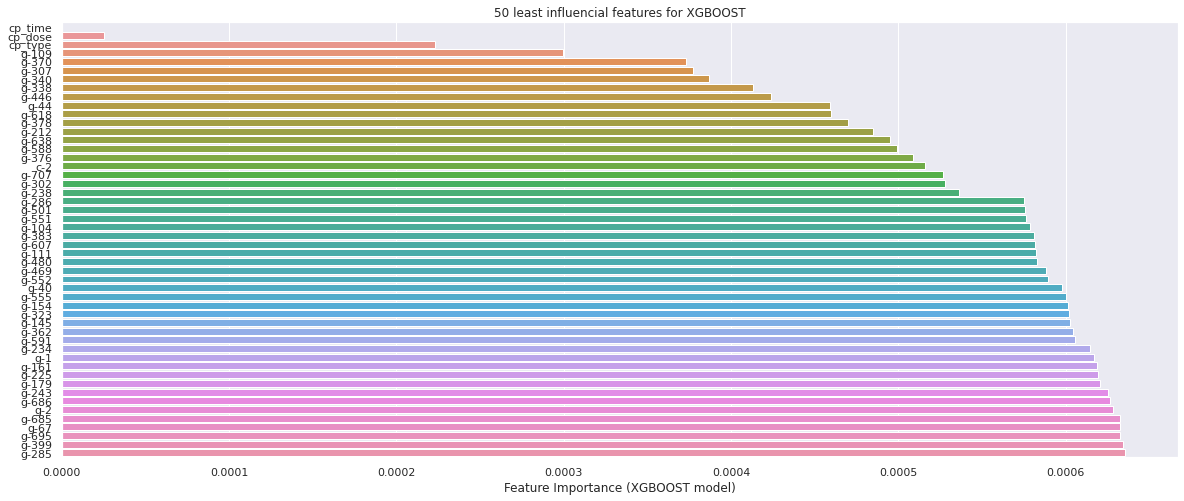

In [67]:
# Analysing least influencial features
xgb_mean_feature_imp = xgb_importance.mean().sort_values()

plt.figure(figsize = (20,8))
sns.barplot(y= xgb_mean_feature_imp.head(50).index.tolist(), x = xgb_mean_feature_imp.head(50).values)
plt.title('50 least influencial features for XGBOOST')
plt.xlabel('Feature Importance (XGBOOST model)')

* Suprisingly cp_time, cp_dose, cp_type are least important features for XGBOOST classifier

Text(0.5, 0, 'Feature Importance (XGBOOST model)')

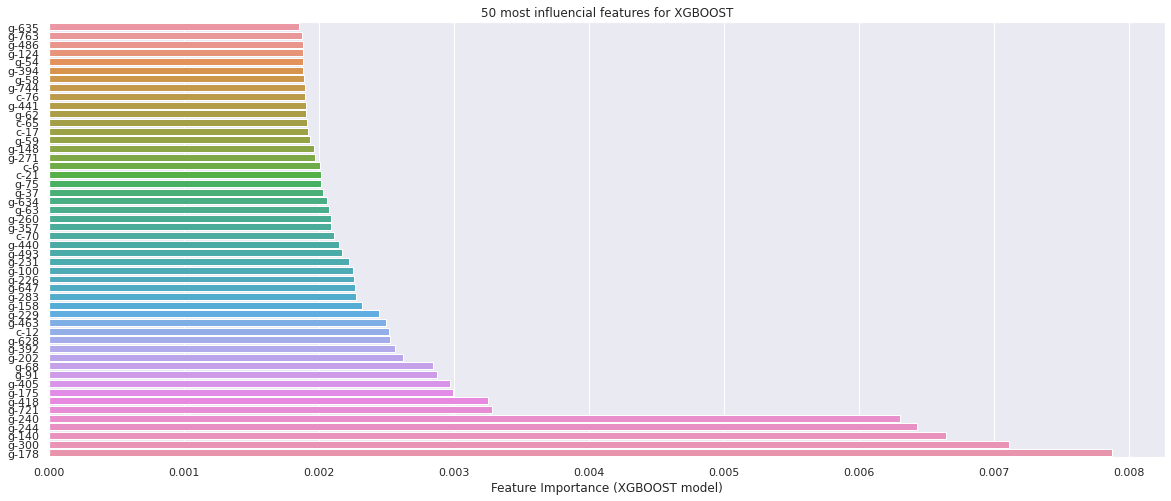

In [68]:
# Analysing least influencial features

plt.figure(figsize = (20,8))
sns.barplot(y= xgb_mean_feature_imp.tail(50).index.tolist(), x = xgb_mean_feature_imp.tail(50).values)
plt.title('50 most influencial features for XGBOOST')
plt.xlabel('Feature Importance (XGBOOST model)')

* Top predictor the drug mechanism of action seem to be  gene expression features

Text(0.5, 0, 'Feature Importance (LogisticRegression model)')

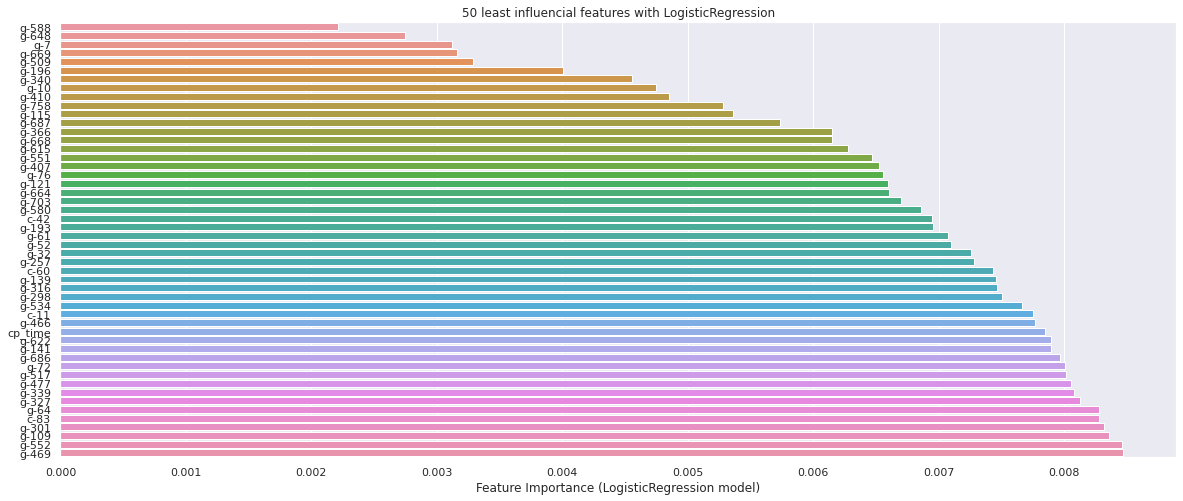

In [69]:
# Analysing least influencial features
lr_abs_mean_importance = feature_importance_lr.abs().mean().sort_values()


plt.figure(figsize = (20,8))
sns.barplot(y= lr_abs_mean_importance.head(50).index.tolist(), x = lr_abs_mean_importance.head(50).values)
plt.title('50 least influencial features with LogisticRegression')
plt.xlabel('Feature Importance (LogisticRegression model)')

Text(0.5, 0, 'Feature Importance (LogisticRegression model)')

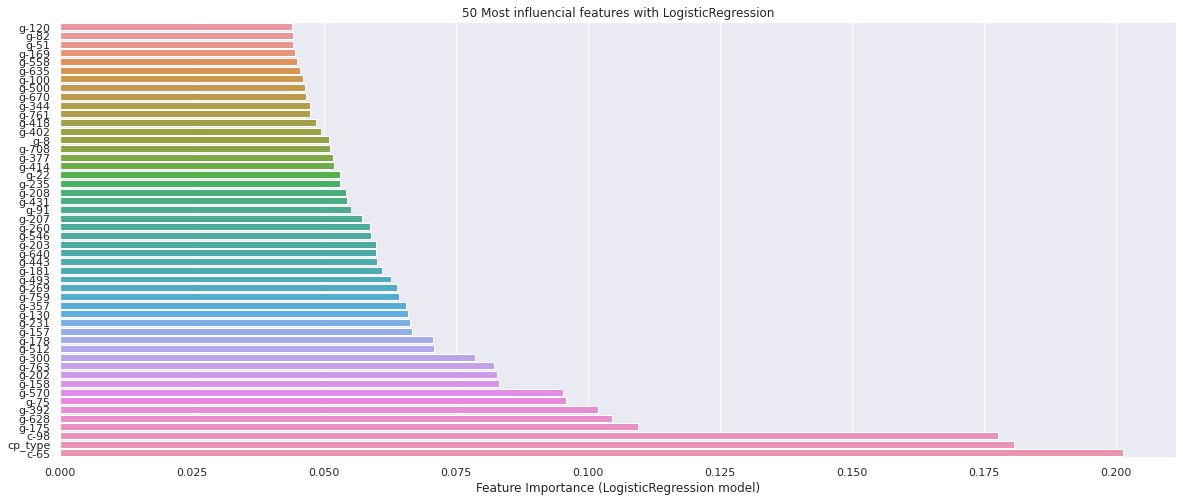

In [70]:
# Analysing least influencial features
lr_abs_mean_importance = feature_importance_lr.abs().mean().sort_values()


plt.figure(figsize = (20,8))
sns.barplot(y= lr_abs_mean_importance.tail(50).index.tolist(), x = lr_abs_mean_importance.tail(50).values)
plt.title('50 Most influencial features with LogisticRegression')
plt.xlabel('Feature Importance (LogisticRegression model)')

***By analysis the individual estimator of Multioutput classifiers a more nuanced analysis of feature importance can be performed***



***So with LogisticRegression and XGBOOST the best score I have been able to acheive around 0.87 AUC and 0.0160 Log loss values***